# Plasma Line

This will show a simple example of how to create a plasma line using the object.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ISRSpectrum import PLspecinit

## Ionosphere Profile

Create a simple ionosphere profile containing, with only the electron density, ion temperature and electron temperature. If a more accurate model is desired createa  new example profile function.

In [2]:
# %% Test functions
def chapman_func(z, H_0, Z_0, N_0):
    """This function will return the Chapman function for a given altitude vector z.  All of the height values are assumed km.

    Parameters
    ----------
    z : ndarray
        An array of z values in km.
    H_0 : float
        A single float of the scale height in km.
    Z_0 : float
        The peak density location.
    N_0 : float
        The peak electron density.

    Returns
    -------
    Ne : ndarray
        Electron density as a function of z in m^{-3}
    """
    z1 = (z - Z_0) / H_0
    Ne = N_0 * np.exp(0.5 * (1 - z1 - np.exp(-z1)))
    return Ne


def temp_profile(z, T0=1000.0, z0=100.0):
    """This function creates a temperature profile using arc tan functions for test purposes.

    Parameters
    ----------
    z : ndarray
        An array of z values in km.
    T0 : ndarray
        The value of the lowest temperature in K.
    z0 : ndarray
        The middle value of the atan functions along alitutude. In km.

    Returns
    -------
    Te : ndarray
        The electron temperature profile in K. 1700*(atan((z-z0)2*exp(1)/400-exp(1))+1)/2 +T0
    Ti : ndarray
        The ion temperature profile in K. 500*(atan((z-z0)2*exp(1)/400-exp(1))+1)/2 +T0
    """
    zall = (z - z0) * 2.0 * np.exp(1) / 400.0 - np.exp(1)
    atanshp = (np.tanh(zall) + 1.0) / 2
    Te = 1700 * atanshp + T0
    Ti = 500 * atanshp + T0

    return (Te, Ti)


def example_profile():
    """Creates profiles for ion temperature, electron density and electron temperature.
    Returns
    -------
    z : ndarray
        Height in km.
    Ne : ndarray
        Electron density as a function of z in m^{-3}
    Te : ndarray
        The electron temperature profile in K. 1700*(atan((z-z0)2*exp(1)/400-exp(1))+1)/2 +T0
    Ti : ndarray
        The ion temperature profile in K. 500*(atan((z-z0)2*exp(1)/400-exp(1))+1)/2 +T0
    """
    z = np.linspace(100, 1000, 100)
    N_0 = 1e12
    z_0 = 250.0
    H_0 = 50.0
    Ne_profile = chapman_func(z, H_0, z_0, N_0)
    (Te_prof, Ti_prof) = temp_profile(z)
    return (z, Ne_profile, Te_prof, Ti_prof)

## 

## Form Spectra at Each Altitude

Create a PLspec object. Since this is made with the intent to use this with a polyphase filter bank implementation of the plasma line the frequency space is broken up into channels. The number of channels determines the number of polyphase filter banks that will be used to create a plasma line signal. The nfreq_pfb parameter is the frequency resolution of these sub bands to create a plasma line spectrum, either upshifted or downshifted.

The overall sampling frequency is 25 MHz, while the number of channels is 250 and the resolution of the frequency in each channel is 1024. This gives a channel width of 100 kHz. From inspection of plasma line data from Millstone Hill the bandwidth of an upshifted or down shifted line is less than 20 kHz, FWHM. With frequency sampling resolution of 1024 perchannel this is something like 200 samples along the main part of line. 



In [3]:
z, Ne, Te, Ti = example_profile()

fs = 25e6
nfreqchans = 250
nfreq_pfb = 1024
nfreqall = nfreqchans * nfreq_pfb
# create the PLspec object
pls = PLspecinit(
    centerFrequency=440.2 * 1e6,
    bMag=0.4e-4,
    dFlag=False,
    fs=fs,
    nchans=nfreqchans,
    nfreq_pfb=nfreq_pfb,
)

pl_cf = np.zeros((len(z), 2))
spec = np.zeros((nfreqall, len(z)))

# go through each of the altitudes and create the plasma line picture.
for inum, (irng, ine, ite, iti) in enumerate(zip(z, Ne, Te, Ti)):
    data_vec = np.array([[ine, iti], [ine, ite]])

    pld = pls.get_ul_spec(
        data_vec, 0.0, alphadeg=90.0, rcsflag=True, freqflag=True, Tpe=1.0, posflag=True
    )
    (f_lo, sp_lo, f_hi, sp_hi, rcs, freqs, pos_l, pos_h) = pld
    pl_cf[inum] = freqs

    for isplo, isphi, iposl, iposh in zip(sp_lo, sp_hi, pos_l, pos_h):
        spec[iposl, inum] += isplo
        spec[iposh, inum] += isphi

## Final Plotting

Plot the spectra along with the plasma center frequencies.

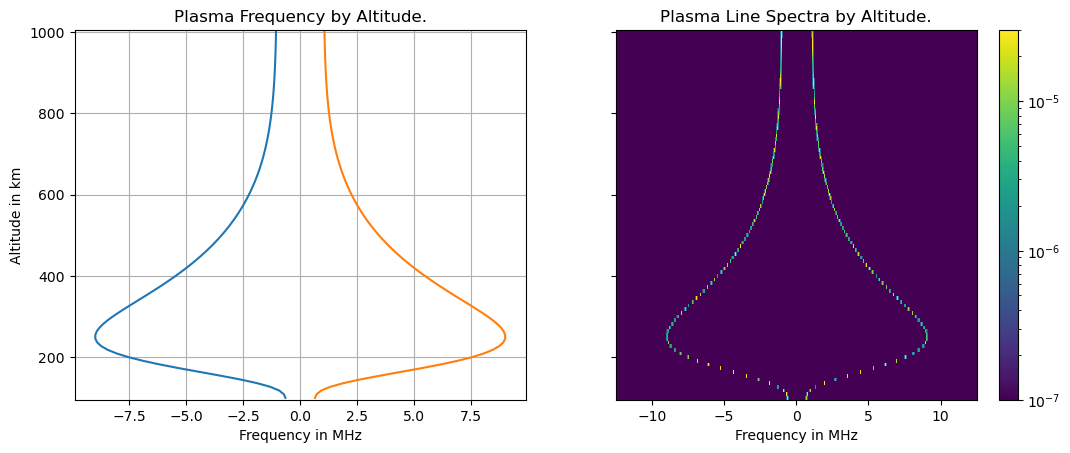

In [4]:
pcmnorm = norm = LogNorm(vmin=1e-7, vmax=3e-5)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12.8, 4.8])
ax1.plot(pl_cf * 1e-6, z)
ax1.grid(True)
ax1.set_xlabel("Frequency in MHz")
ax1.set_ylabel("Altitude in km")
ax1.set_title("Plasma Frequency by Altitude.")

# Add the machine epsilon to avoid issues with log.
d_eps = np.finfo(spec.dtype).eps

# define a meshgrid for the altitude and frequency space.
freqar = np.fft.fftshift(np.fft.fftfreq(nfreqall, 1 / fs))
freqm, zm = np.meshgrid(freqar, z)

pcm = ax2.pcolormesh(freqm * 1e-6, zm, spec.T + d_eps, norm=pcmnorm)
ax2.set_xlabel("Frequency in MHz")
ax2.set_title("Plasma Line Spectra by Altitude.")
fig.colorbar(pcm, ax=ax2)
# fig.savefig("plfreqs.png",dpi=300)